In [1]:
from stonesoup.sensor.action import Action


class ChangeDirectionAction(Action):
    """Simply changes the direction that the sensor is looking in when the action `end_time` is
    reached."""
    def act(self, current_time, timestamp, init_value):
        """Only change to target direction once `end_time` is reached. Otherwise, keep same value.

        Parameters
        ----------
        current_time: datetime.timedelta
            Current time (stored by sensor)
        timestamp: datetime.timedelta
            Modification of direction ends at this time stamp
        init_value: Any
            Current value of the direction

        Returns
        -------
        Any
            The new value of the direction
        """
        if timestamp >= self.end_time:
            return self.target_value  # target direction
        else:
            return init_value  # same direction
        
from stonesoup.sensor.action import ActionGenerator
from stonesoup.base import Property
from stonesoup.sensor.sensor import Sensor


class DirectionActionsGenerator(ActionGenerator):
    """Return an action for each possible direction that the sensor can look at by `end_time`."""
    owner: Sensor = Property(
        doc="Sensor with `timestamp`, `direction` and `potential_directions` attributes")

    @property
    def default_action(self):
        """The default action is to remain "looking" in the same direction, so the `target_value`
        is the same as the `current_value`."""
        return ChangeDirectionAction(generator=self,
                                     end_time=self.end_time,
                                     target_value=self.current_value)

    def __contains__(self, item):
        """Can switch to any direction in any time frame (as long as it is sensible. e.g. we
        shouldn't expect to be able to look in the direction "up" or "weast")."""
        if isinstance(item, ChangeDirectionAction):
            item = item.target_value  # grab the target value of the action to check against

        potential_directions = self.owner.potential_directions

        return item in potential_directions  # if it's a potential direction, then it is possible

    def __iter__(self):
        """
        yield an action for every potential direction that is possible to look at in time frame.
        """
        for direction in self.owner.potential_directions:
            yield ChangeDirectionAction(generator=self,
                                        end_time=self.end_time,
                                        target_value=direction)
            
from numpy import pi

from stonesoup.sensor.sensor import Sensor
from stonesoup.sensor.actionable import ActionableProperty
from stonesoup.models.measurement.linear import LinearGaussian
from stonesoup.models.measurement.nonlinear import Cartesian2DToBearing
from stonesoup.types.detection import TrueDetection
from stonesoup.types.array import StateVector


class DirectedSensor(Sensor):
    direction: str = ActionableProperty(doc="Direction that sensor is looking in",
                                        generator_cls=DirectionActionsGenerator)

    @property
    def potential_directions(self):
        return ["East", "North", "West", "South"]

    @property
    def potential_directions_angles(self):
        """Need a slightly more meaningful definition of direction when calculating what falls in
        to the sensor's FoV."""
        return {string: angle for string, angle
                in zip(self.potential_directions, [.0, pi/2, pi, 3*pi/2])}

    @property
    def direction_angle(self):
        return StateVector([0, 0, self.potential_directions_angles[self.direction]])

    @property
    def measurement_model(self):
        return LinearGaussian(ndim_state=4,
                              mapping=(0, 2),
                              noise_covar=np.eye(2))

    def measure(self, ground_truths, noise=None, **kwargs):

        detections = set()
        for truth in ground_truths:

            bearing_calculator = Cartesian2DToBearing(ndim_state=4,
                                                      mapping=(0, 2),
                                                      noise_covar=np.diag([0, 0]),
                                                      translation_offset=self.position,
                                                      rotation_offset=self.direction_angle)
            bearing = bearing_calculator.function(truth, noise=False)

            # Do not measure if state not in FoV (90 degrees)
            if bearing > pi/4 or bearing < -pi/4:
                continue

            measurement_vector = self.measurement_model.function(truth, noise=False, **kwargs)
            detection = TrueDetection(measurement_vector,
                                      measurement_model=self.measurement_model,
                                      timestamp=truth.timestamp,
                                      groundtruth_path=truth)
            detections.add(detection)

        return detections
    
import datetime
from stonesoup.platform.base import FixedPlatform
from stonesoup.types.state import State

now = datetime.datetime.now()

sensor = DirectedSensor(direction="North")  # sensor starts by looking "North"

# Need to fix sensor to platform for use in detection simulator
platform = FixedPlatform(position_mapping=(0, 2),
                         states=[State([0, 0, 0, 0], timestamp=now)],
                         sensors=[sensor])

five_sec_actions = DirectedSensor(direction="North").actions(now + datetime.timedelta(seconds=5))
five_sec_actions

{DirectionActionsGenerator(
     owner=DirectedSensor(
               direction=North,
               resolutions=None,
               rotation_offset=None,
               mounting_offset=None,
               movement_controller=None),
     attribute=direction,
     start_time=2024-02-08 18:39:09.336509,
     end_time=2024-02-08 18:39:09.336509,
     resolution=None)}

In [2]:
generator = five_sec_actions.pop()
generator.default_action

for action in generator:
    print(action)
    
sensor.add_actions({action})
sensor.scheduled_actions

print("Timestamp at 0s: ", sensor.timestamp)
print("Direction at 0s: ", sensor.direction)

sensor.act(now + datetime.timedelta(seconds=2))

print("Timestamp at 2s: ", sensor.timestamp)
print("Direction at 2s: ", sensor.direction)

sensor.act(now + datetime.timedelta(seconds=5))
print("Timestamp at 5s: ", sensor.timestamp)
print("Direction at 5s: ", sensor.direction)

from stonesoup.models.transition.linear import ConstantVelocity, \
    CombinedLinearGaussianTransitionModel
from stonesoup.types.state import GaussianState
import datetime
import numpy as np
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from stonesoup.simulator.platform import PlatformDetectionSimulator


transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.1),
                                                          ConstantVelocity(0.1)])
now = datetime.datetime.now()
initial_state = GaussianState([0, 0, 0, 0], covar=np.diag([25, 1, 25, 1]), timestamp=now)
groundtruth_sim = MultiTargetGroundTruthSimulator(transition_model,
                                                  initial_state,
                                                  number_steps=100)

sensor = DirectedSensor(direction="North")  # sensor starts by looking "North"

# Need to fix sensor to platform for use in detection simulator
platform = FixedPlatform(position_mapping=(0, 2),
                         states=[State([0, 0, 0, 0], timestamp=now)],
                         sensors=[sensor])

detector = PlatformDetectionSimulator(groundtruth_sim, {platform})

groundtruths = set()
all_detections = set()

for time_index, (time, detections) in enumerate(detector, 1):

    if time_index == 20:
        generator = sensor.actions(time + datetime.timedelta(seconds=5)).pop()
        for action in generator:  # loop through generator, get last action (South)
            pass
        sensor.add_actions({action})
    elif time_index == 40:
        generator = sensor.actions(time + datetime.timedelta(seconds=5)).pop()
        action = next(iter(generator))  # get first action (East)
        sensor.add_actions({action})
    groundtruths.update(groundtruth_sim.current[1])
    all_detections.update(detections)

print(f"num ground truths = {len(groundtruths)}, num detections = {len(all_detections)}")

ChangeDirectionAction(
    end_time=2024-02-08 18:39:09.336509,
    target_value=East,
    generator=DirectionActionsGenerator(
                  owner=DirectedSensor(
                            direction=North,
                            resolutions=None,
                            rotation_offset=None,
                            mounting_offset=None,
                            movement_controller=None),
                  attribute=direction,
                  start_time=2024-02-08 18:39:09.336509,
                  end_time=2024-02-08 18:39:09.336509,
                  resolution=None))
ChangeDirectionAction(
    end_time=2024-02-08 18:39:09.336509,
    target_value=North,
    generator=DirectionActionsGenerator(
                  owner=DirectedSensor(
                            direction=North,
                            resolutions=None,
                            rotation_offset=None,
                            mounting_offset=None,
                            movement_co

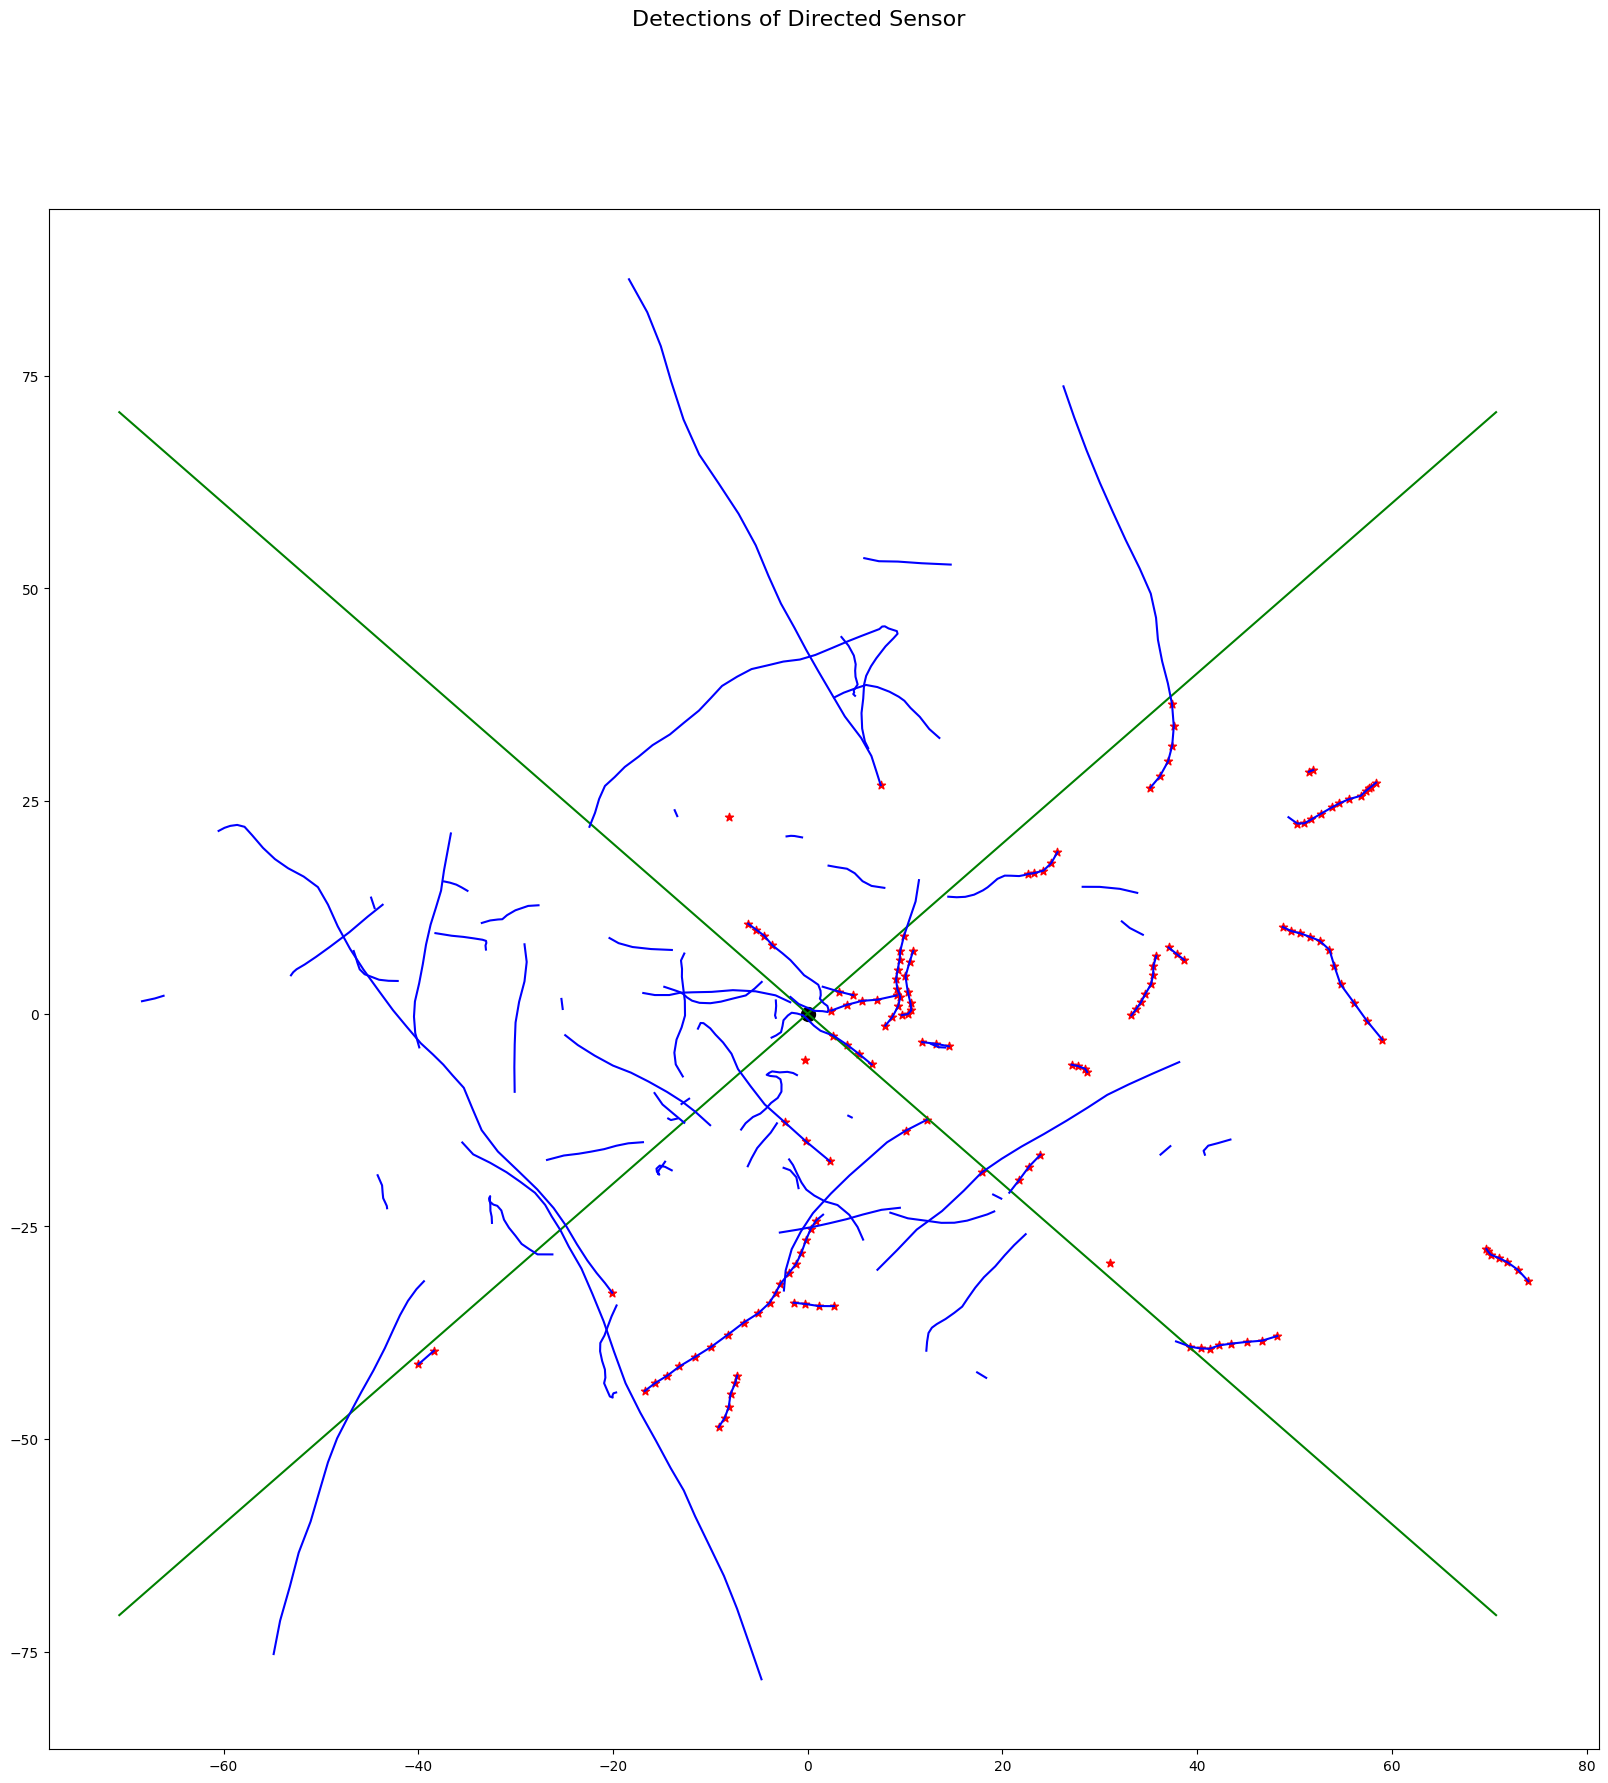

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.suptitle("Detections of Directed Sensor", fontsize=16)
ax.figure.set_size_inches(20, 20)

# Plot sensor possible FoVs
for bearing in (pi/4, 3*pi/4, 5*pi/4, 7*pi/4):
    ax.plot((0, 100*np.cos(bearing)), (0, 100*np.sin(bearing)), c="green")

# Plot sensor location
ax.scatter(0, 0, s=100, c="black")

# Plot ground truths
for truth in groundtruths:
    ax.plot(*np.array([state.state_vector[(0, 2), :].flatten() for state in truth]).T, c="blue")
    ax.figure.set_size_inches(20, 20)

# Plot detections
for detection in all_detections:
    ax.scatter(*detection.state_vector, c="red", marker="*")